# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [1]:
import keras
import numpy as np
import pandas as pd
import sklearn

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet, ValidationData
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.optimizer.gradient_descent_optimizer import GradientDescentOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker
from lib.ml.util.lr_scheduler import ReduceLROnPlateau

from lib.ml.util.activation_function import RELU_ACTIVATION
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
    split_turbine_dataset,
    window_and_split_turbine_dataset
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import plot_loss_and_val_loss, plot_diff

from sklearn.discriminant_analysis import StandardScaler

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)

3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [3]:
scaler = StandardScaler()

dataset = process_wind_turbine_dataset(
    archive,
    scaler=scaler,
)

dataset.head(5)

,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power,Location_1,Location_2,Location_3,Location_4
0,-0.804021,0.837857,-0.562194,-1.355386,-1.850563,-0.555885,-0.391588,-1.845008,0.151429,1.0,0.0,0.0,0.0
1,-0.808581,0.896680,-0.552661,-1.049536,-0.957421,-0.505925,-0.431150,-1.017793,0.133128,1.0,0.0,0.0,0.0
2,-0.881539,1.190795,-0.562194,-1.424449,-1.353283,-0.535901,-0.510276,-1.348679,0.114574,1.0,0.0,0.0,0.0
3,-0.854179,1.014326,-0.571727,-1.424449,-1.382727,-1.435186,-0.955355,-1.789861,0.095579,1.0,0.0,0.0,0.0
4,-0.858739,1.014326,-0.581260,-0.847281,-0.813472,-1.435186,-1.163059,-1.128089,0.076309,1.0,0.0,0.0,0.0


In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = window_and_split_turbine_dataset(
    dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9, window_size=10
)

# x_train, y_train, x_valid, y_valid, x_test, y_test = split_turbine_dataset(
#     dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9
# )

print("x_train = " + str(x_train.shape))
print("y_train = " + str(y_train.shape))
print("x_valid = " + str(x_valid.shape))
print("y_valid = " + str(y_valid.shape))
print("x_test = " + str(x_test.shape))
print("y_test = " + str(y_test.shape))

validation_data = ValidationData(x_valid, y_valid)

x_train = (130, 100886)
y_train = (1, 100886)
x_valid = (130, 11210)
y_valid = (1, 11210)
x_test = (130, 28024)
y_test = (1, 28024)


## Train NN using genetic optimizer

1. Define neural network.

In [5]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

In [ ]:
trained_model = compiled_model.fit(
    x_train, y_train, 300, validation_data=validation_data
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

In [ ]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [ ]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

## Train NN using gradient descent optimizer

1. Define Neural network

In [9]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(1024, activation_fun=RELU_ACTIVATION),
        Dense(1024, activation_fun=RELU_ACTIVATION),
        Dense(512, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

lr_scheduler = ReduceLROnPlateau(lr=1e-3, patience=10, factor=0.1, min_lr=1e-7)
opt = GradientDescentOptimizer(lr_scheduler=lr_scheduler)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    lr_scheduler=lr_scheduler,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/20 [00:00<?, ?it/s]

loss = 0.044619692243489405


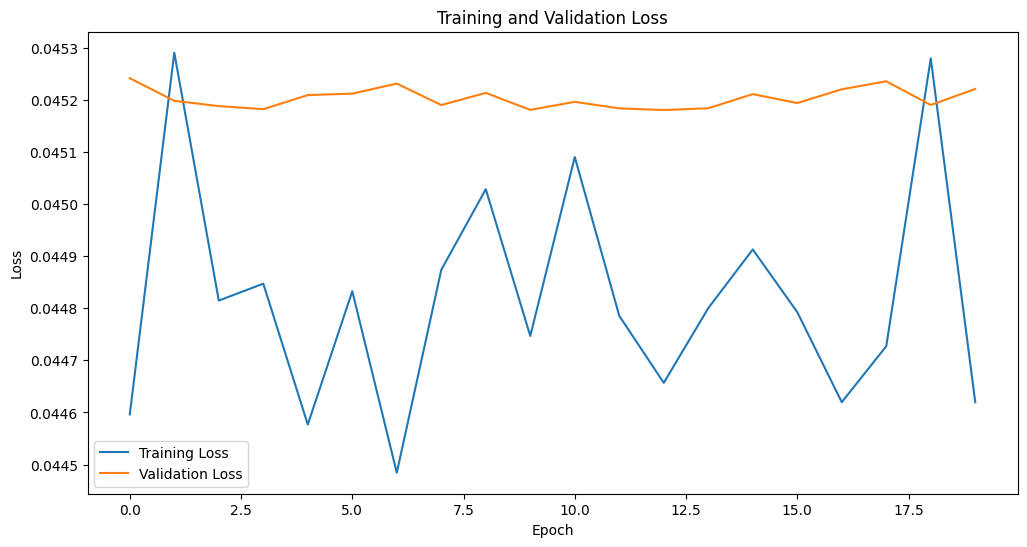

In [13]:
trained_model = compiled_model.fit(
    x_train, y_train, 20, validation_data=validation_data, batch_size=4048
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.0449557581133249
R2 score = -0.31210468143838144


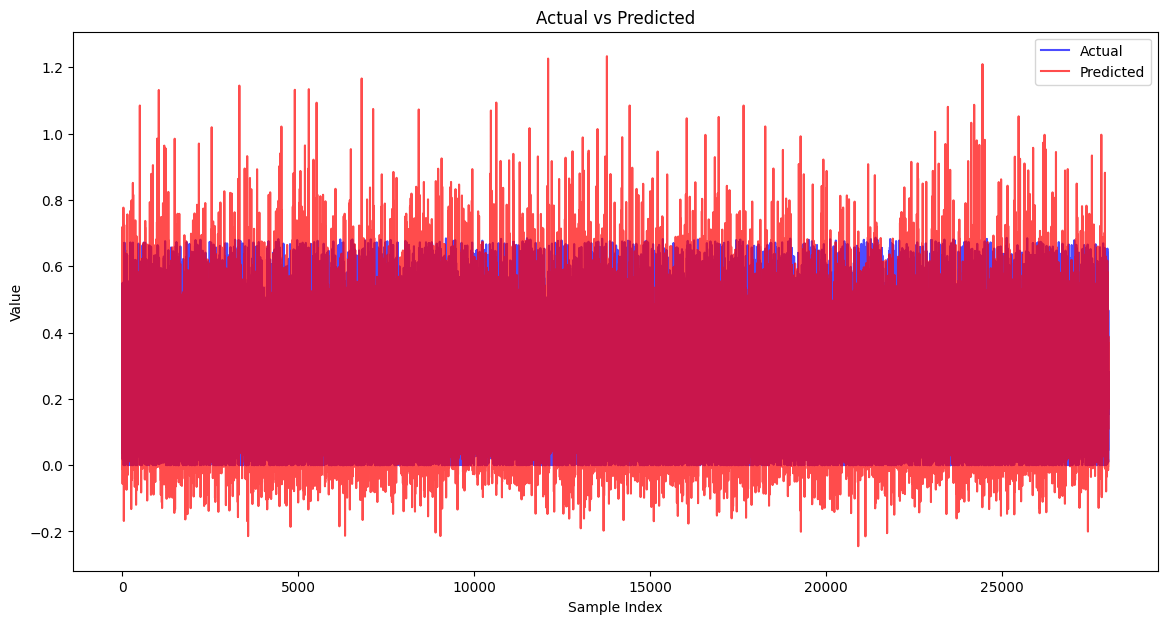

In [14]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [ ]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

## Train NN using tensorflow and Adam optimizer

1. Define Neural network

In [8]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[0],)),
        keras.layers.Dense(units=1024, activation="relu"),
        keras.layers.Dense(units=1024, activation="relu"),
        keras.layers.Dense(units=512, activation="relu"),
        keras.layers.Dense(units=1),
    ]
)

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1024)           │       134,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,709,057 (6.52 MB)

 Trainable params: 1,709,057 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

2. Train neural network.

In [6]:
history = model.fit(
    x_train.T, y_train.reshape(-1), epochs=20, batch_size=32, verbose=1
)

Epoch 1/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0352
Epoch 2/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 6.4146e-04
Epoch 3/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 4.4636e-04
Epoch 4/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 3.3525e-04
Epoch 5/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 2.9271e-04
Epoch 6/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 2.6242e-04
Epoch 7/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 2.3529e-04
Epoch 8/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 2.2586e-04
Epoch 9/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 1.9892e-04
Epoch 10/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.9838e-04
Epoch 11/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 1.8244e-04
Epoch 12/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 1.7552e-04
Epoch 13/20
3153/3153 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.7227e-04
Epoch 14/20
3153/3153 ━━━━━━━━━━━━━━━━

3. Test neural network.

876/876 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
loss = 0.06797562500461007
R2 score = 0.9954084022404747


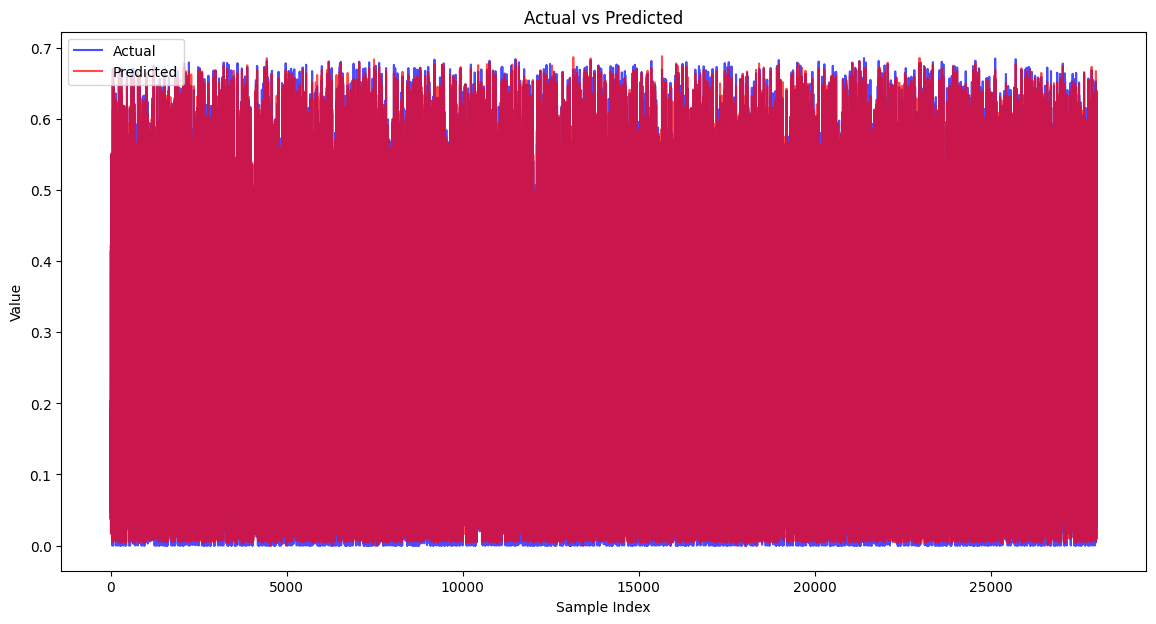

In [7]:
y_predicted = model.predict(x_test.T)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())